# Churn Reasons (Weighted) — NLP & Sentiment (Colab Ready)

This notebook:
- Uploads or loads `oa_churn_requests_sample.csv`
- Builds **weighted text**: `secondary × 3 + primary × 2 + notes × 1`
- Cleans text, runs **sentiment analysis** (TextBlob)
- Outputs **colored sentiment bar**, **top keywords bar**, **word cloud**
- Also shows **top primary** and **top secondary** reasons as separate bars
- Saves an **enriched CSV** (for Looker) with weighted text & sentiment columns

> If running in **Colab**, first use the **Upload** cell below.


In [ ]:
# (Colab) Upload your CSV if needed
# from google.colab import files
# uploaded = files.upload()  # then pick oa_churn_requests_sample.csv


In [ ]:
# %pip install nltk textblob wordcloud scikit-learn pandas matplotlib --quiet
import os, re
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

plt.rcParams['figure.figsize'] = (10,5)
plt.rcParams['axes.grid'] = True

OUT_DIR = Path('data_work/nlp_outputs')
OUT_DIR.mkdir(parents=True, exist_ok=True)
print('Output directory:', OUT_DIR.resolve())

from google.colab import files
uploaded = files.upload()

Output directory: /content/data_work/nlp_outputs


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Saving oa_churn_requests_sample.csv to oa_churn_requests_sample.csv


In [ ]:
# Point to your CSV path; change if needed
CSV_PATH = 'oa_churn_requests_sample.csv'

# Columns to use
PRIMARY_COL = 'churn_primary_reason'
SECONDARY_COL = 'churn_secondary_reason'
NOTES_COL = 'churn_notes'

df = pd.read_csv(CSV_PATH)

missing = [c for c in [PRIMARY_COL, SECONDARY_COL, NOTES_COL] if c not in df.columns]
assert not missing, f"Missing required columns: {missing}. Found: {list(df.columns)}"

print('Loaded rows:', len(df))

Loaded rows: 506


In [ ]:
# Weighting: secondary x3, primary x2, notes x1
def norm_text(x):
    if pd.isna(x): return ''
    return str(x).strip()

sec = df[SECONDARY_COL].apply(norm_text)
pri = df[PRIMARY_COL].apply(norm_text)
nts = df[NOTES_COL].apply(norm_text)

df['weighted_text_raw'] = (sec + ' ') * 3 + (pri + ' ') * 2 + nts

print('Example weighted text (first 2 rows):')
print(df['weighted_text_raw'].head(2).tolist())

Example weighted text (first 2 rows):
['Other Sales-related issues Other Sales-related issues Other Sales-related issues Sales Sales Does not own this location', 'Other onboarding-related issues Other onboarding-related issues Other onboarding-related issues Onboarding Onboarding never went through ELC, was never contacted again after CW. Been reaching out to support since Feb to churn']


In [ ]:
EN_STOP = set(stopwords.words('english'))
def clean_text(s: str) -> str:
    s = s.lower()
    s = re.sub(r'[^a-z\s]', ' ', s)
    toks = [w for w in s.split() if w and w not in EN_STOP]
    return ' '.join(toks)

df['weighted_text'] = df['weighted_text_raw'].fillna('').astype(str).apply(clean_text)
print('Non-empty weighted rows:', (df['weighted_text'].str.strip()!='').sum(), '/', len(df))

Non-empty weighted rows: 506 / 506


In [ ]:
def polarity_safe(s: str) -> float:
    if not isinstance(s, str) or s.strip() == '':
        return 0.0
    return float(TextBlob(s).sentiment.polarity)

df['sentiment'] = df['weighted_text'].apply(polarity_safe)

def label_sentiment(x: float) -> str:
    if x > 0.05:  return 'Positive'
    if x < -0.05: return 'Negative'
    return 'Neutral'

df['sentiment_label'] = df['sentiment'].apply(label_sentiment)

enriched_path = OUT_DIR / 'churn_notes_weighted_enriched.csv'
df.to_csv(enriched_path, index=False)
print('Saved enriched CSV ->', enriched_path)

Saved enriched CSV -> data_work/nlp_outputs/churn_notes_weighted_enriched.csv


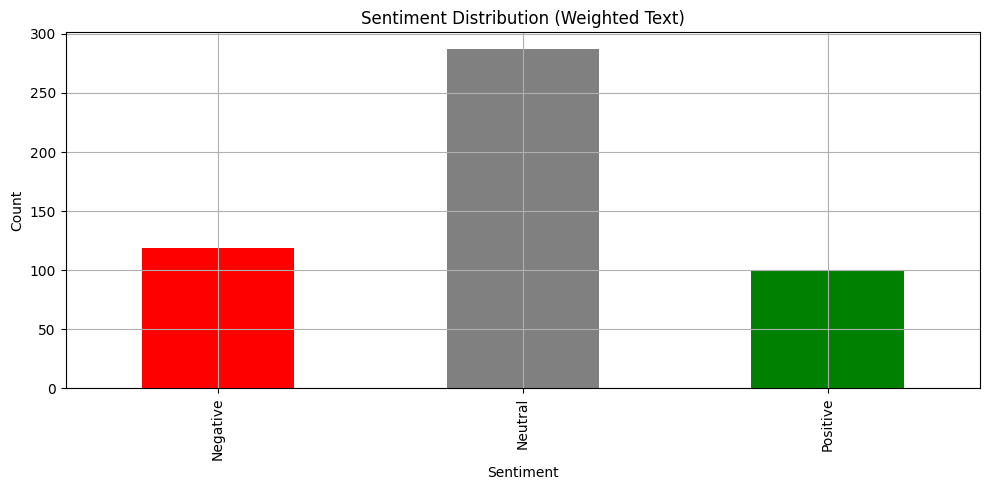

Average sentiment: -0.000505568390759624


In [ ]:
ax = (df['sentiment_label']
        .value_counts()
        .reindex(['Negative','Neutral','Positive'])
        .fillna(0)
        .plot(kind='bar', color=['red','gray','green']))
ax.set_title('Sentiment Distribution (Weighted Text)')
ax.set_xlabel('Sentiment'); ax.set_ylabel('Count')
plt.tight_layout(); plt.show()

print('Average sentiment:', df['sentiment'].mean())

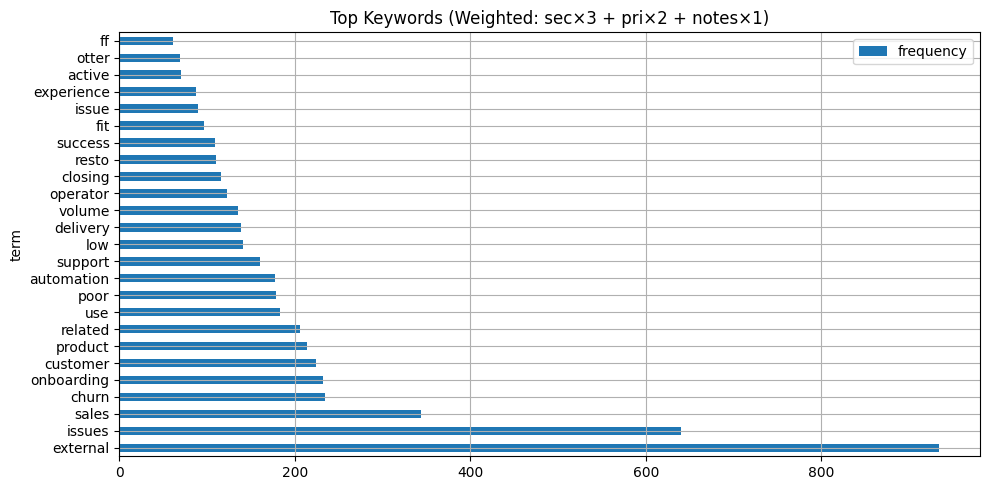

In [ ]:
text_for_vec = df.loc[df['weighted_text'].str.strip()!='', 'weighted_text']
vectorizer = CountVectorizer(max_features=5000)
X = vectorizer.fit_transform(text_for_vec)

vocab = np.array(vectorizer.get_feature_names_out())
freqs = np.asarray(X.sum(axis=0)).ravel()
order = freqs.argsort()[::-1]
top_k = 25

top_terms = pd.DataFrame({'term': vocab[order][:top_k], 'frequency': freqs[order][:top_k]})
top_terms.to_csv(OUT_DIR / 'top_keywords_weighted.csv', index=False)
top_terms.plot(kind='barh', x='term', y='frequency', color='tab:blue')
plt.title('Top Keywords (Weighted: sec×3 + pri×2 + notes×1)')
plt.tight_layout(); plt.show()

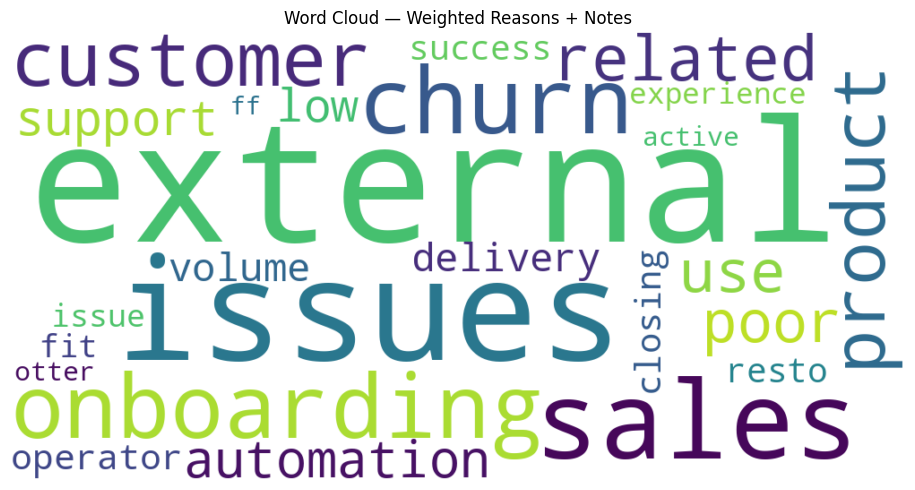

In [ ]:
freq_dict = dict(zip(top_terms['term'], top_terms['frequency']))
wc = WordCloud(width=1000, height=500, background_color='white').generate_from_frequencies(freq_dict)
plt.imshow(wc, interpolation='bilinear'); plt.axis('off')
plt.title('Word Cloud — Weighted Reasons + Notes')
plt.tight_layout(); plt.show()

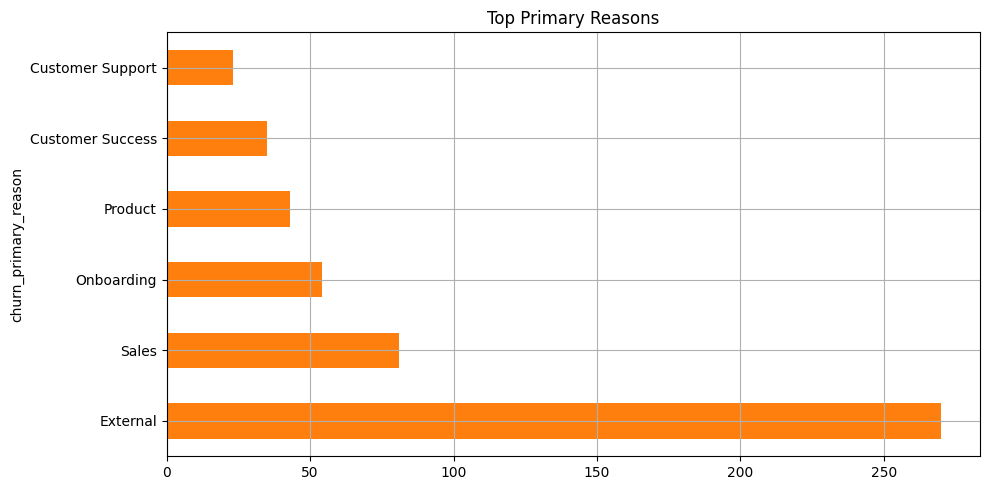

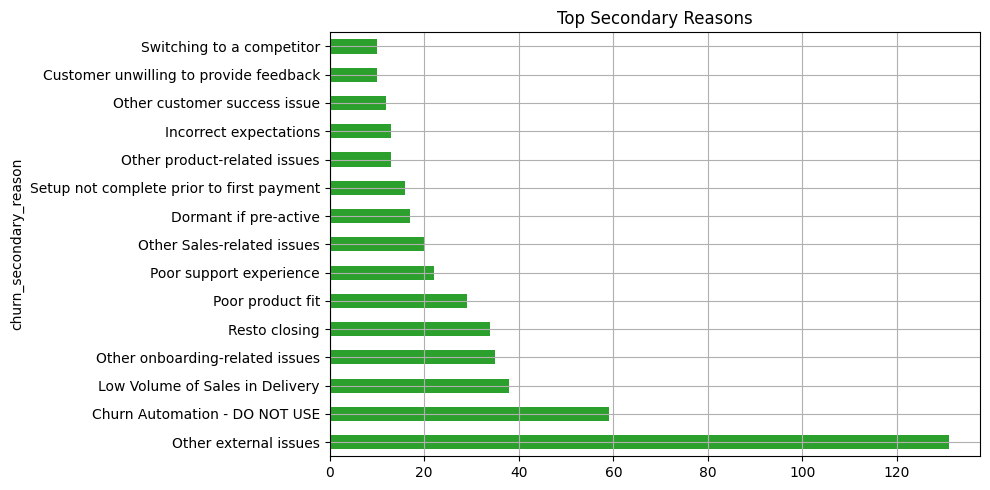

In [ ]:
# Top primary reasons
prim_ct = (df[PRIMARY_COL].fillna('Unknown').astype(str).str.strip()
           .replace({'': 'Unknown'})
           .value_counts().head(15))
prim_ct.to_csv(OUT_DIR / 'top_primary_reasons.csv')
prim_ct.plot(kind='barh', color='tab:orange')
plt.title('Top Primary Reasons'); plt.tight_layout(); plt.show()

# Top secondary reasons
sec_ct = (df[SECONDARY_COL].fillna('Unknown').astype(str).str.strip()
          .replace({'': 'Unknown'})
          .value_counts().head(15))
sec_ct.to_csv(OUT_DIR / 'top_secondary_reasons.csv')
sec_ct.plot(kind='barh', color='tab:green')
plt.title('Top Secondary Reasons'); plt.tight_layout(); plt.show()